## Load in choice data

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
choice_data_r1=np.load('choice_data_r1.npy')

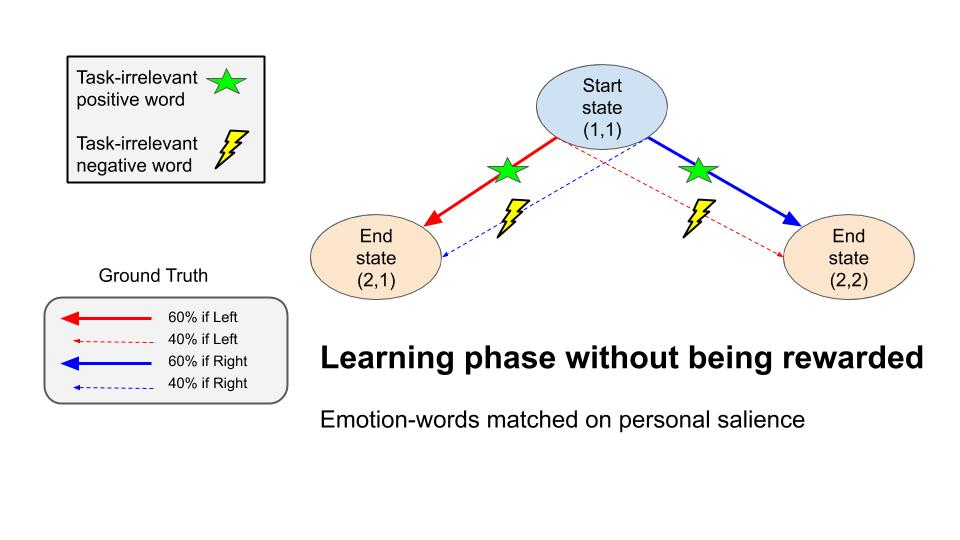

In [5]:
from IPython.display import Image
Image(filename='emotion_r1.jpg') 

##  Modelling pilot data hierarchically: explaining choice data

In the present experiment, participants chose an action to obtain a reward based off a latent transition matrix they've presumably learned in a learning phase, and then must apply that knowledge to a test phase Above you'll see a picture of a condition in which personally-salient words interposed between the state transitions the agent is trying to learn. The hypothesis is that this transition matrix is altered due to experimentally-manipulated features (valence of emotional distractors during learning) and person-specific factors that are not manipulated (level of chronic worry). 

We can conceive of the generative model of my data in the following way as a Bayesian variant of a within-subjects ANOVA. We'll start from the bottom up. Each individual's decision is either a 1 or 0 (did they select the best-available option or not). The best-available option is the action that maximizes the EV according to a greedy policy (which is normative here given that learning has terminated once decision-making begins; that is, if I've learned I have a 60% chance pressing X will get me to the highest reward, and Y will get me there 40% of the time, I should always choose X). 

The $\theta$ parameter determines a subjects' choice, which can be thought of as their decision bias. If their decision bias is 0, it is an index that they're always choosing the worst action. If the bias is 1, they're maximizing performance. 

We use a Bernoulli likelihood to define the **subject-specific** data-generating process to explain their choice data:

$Choice_{i,k,t}$ $\sim$ Bernoulli$(\theta_{i,k})$ Indices: i=subjects, t=trials, k=condition, where k(1) = neutral, k(2) = positive and k(3) = negative. 

These decicision biases, $\theta$, are determied via a joint function of the average bias in the population, $\alpha_0$, a subject-specific factor $\eta_i$, and an experimentally-induced effect, $\gamma_k$. A logistic link function is necessary to take a parameter setting spanning all values to the 0 to 1 range in order to be used to jointly define the mean and variance of the Bernoulli likelihood.

$\theta_{i,k}\,= \begin{cases}
    \text{logistic}\, (\alpha_0 + \eta_{i} + \gamma_{1}),& \text{if } k=1\\
    \text{logistic}\,(\alpha_0 + \eta_{i} + \gamma_{2}),& \text{if } k=2\\
    \text{logistic}\,(\alpha_0 + \eta_{i} + \gamma_{3}),& \text{if } k=3\\
\end{cases}
$

$\gamma_{1}$, $\gamma_{2}$, and $\gamma_{3}$ represent the biases for **each condition** modelled as a fixed effect, where each is drawn from **group-level distribution over condition effects**:

$\gamma_{k}$ $\sim \mathcal{N}(0, \sigma_{experimental})$

We also have a **subject-specific bias** drawn from the population distribution over biases. One can think of this as the tendency to learn well the state transitions in the present task necessary for good performance, marginalized over experimental effects.

$\eta_i$ $\sim$ $\mathcal{N}(0,\sigma_{subject})$

To estimate the group-level standard deviation, we used a uniform distribution ranging from 0 to 15. This allows for greater regularization of parameters. Post-estimation, we also converted parameters to reflect deflections from the grand mean, meeting the sum-to-zero constraint for more interpretability.

The posterior joint distribution one is trying to estimate is: $p(\alpha_0,\eta_i,\gamma_k|data)$. Thus we must estimate $(\text{Baseline}+i+k)$ parameters, which for the present dataset, is a 17-dimensional joint distribution. Below, I use pyStan to fit the model to the data below.

We originally included an interaction term, adding many parameters to estimate, but becaues it barely accounted for any variance & increased model complexity, we removed them from models and plots. Similarly, we also fit a random-effects model for each experimental effect, but failed to converge.

## Build hierarchical model in pyStan

In [11]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  // Grand mean
  real a0;
  
  //Conditions
  vector[NxConditions] aW;
  vector[NxSubjects] aS;
  
  //Group level Prior variance
  real<lower=0.01> sigma_subject;
  real<lower=0.01> sigma_condition;
    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_positive;
vector[NxSubjects] theta_negative;

// Translate to sum-to-zero deflections away from Grand Mean

real b0;
vector[NxConditions] bConditions;
vector[NxSubjects] bSubjects;

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  for ( u in 1:NxConditions){
      for ( b in 1: NxSubjects){
          m[u,b] = a0+aW[u]+aS[b];
      }
  }
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  
  //Effects of Subject
  for (h in 1:NxSubjects){bSubjects[h]=mean(m[1:NxConditions,h])-b0;}
  


for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(a0+aW[1]+aS[k]);
        theta_positive[k] = inv_logit(a0+aW[2]+aS[k]);
        theta_negative[k] = inv_logit(a0+aW[3]+aS[k]);
        
    }
}
model {

    sigma_subject ~ uniform(0.01,10);
    sigma_condition ~ uniform(0.01,10);
    a0 ~ normal(0,10); 
    aW ~ normal(0,sigma_condition);
    aS ~ normal(0,sigma_subject);
    
    for (k in 1:NxSubjects){
    
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive condition choices
            Choice[k,2,:] ~ bernoulli(theta_positive[k]);

            // Negative condition choices
            Choice[k,3,:] ~ bernoulli(theta_negative[k]);    
              
      }
    }
    
'''
data_input = {
              'Ntrials': 40, # trials per condition
              'Choice':choice_data_r1,#choice data
              'NxConditions':3,
              'NxSubjects':13
                    }

# controls={}
# controls['adapt_delta']=0.8

model_fit_no_interaction = StanModel(model_code=model_input)
fit_no_interaction = model_fit_no_interaction.sampling(data=data_input,iter=2000)
print(fit_no_interaction)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1507e9960f7b60eb313be3b1b9018b7 NOW.


Inference for Stan model: anon_model_b1507e9960f7b60eb313be3b1b9018b7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0                   2.38    0.13    2.1  -2.37   1.26   2.41   3.51    6.8    248   1.01
aW[1]                1.18    0.12   1.73  -2.28   0.41   1.11   1.88   5.49    225    1.0
aW[2]               -0.55    0.11   1.73  -4.06  -1.29   -0.6   0.15   3.76    226    1.0
aW[3]               -0.44    0.12   1.73  -3.93  -1.19  -0.49   0.26   3.84    226    1.0
aS[1]               -2.76    0.07   1.23  -5.39   -3.5  -2.74  -1.94  -0.53    319   1.02
aS[2]                 5.3     0.1   2.71   1.36   3.48   4.87   6.53  12.25    781    1.0
aS[3]               -4.21    0.07   1.24   -6.8  -4.97  -4.16  -3.37  -1.89    324   1.02
aS[4]               -0.56    0.07   1.24  -3.15  -1.34  -0.51   0.28    1.7    319   1.02
a

## Plot relevant posterior distributions: Chance below is as if one flips a fair coin to choose an action, i.e., $\theta = 0.5$

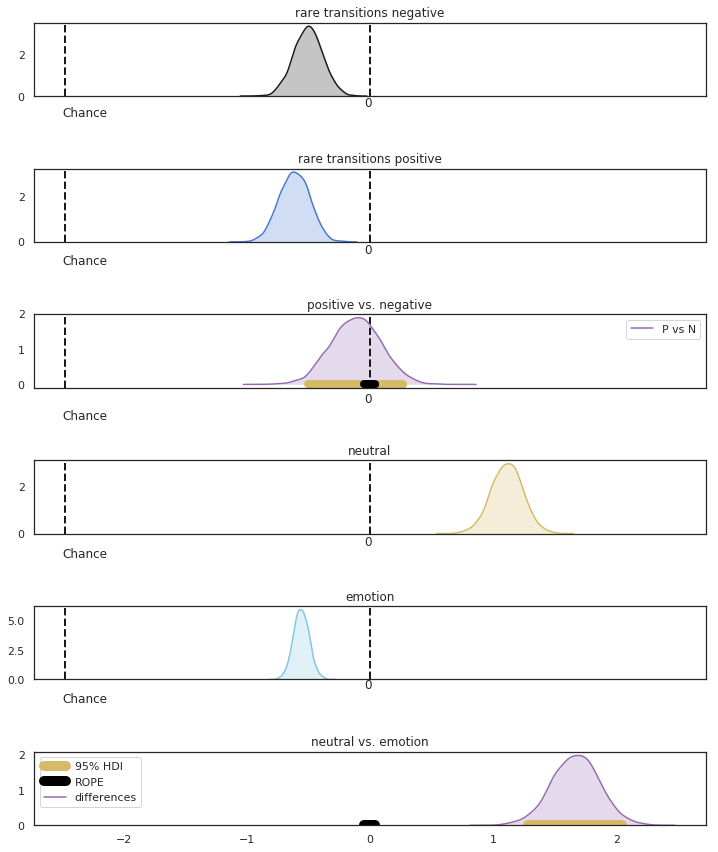

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

fit_df = fit_no_interaction.to_dataframe()
#fit_df.to_csv('Bayesian_rmANOVA_output_GroupPriorsSDs_nointeractions.csv')
#fit_df=pd.read_csv('Bayesian_rmANOVA_output_GroupPriorsSDs_nointeractions.csv')
fit_df.keys()

chain_idx = fit_df['draw']
neutral = fit_df['bConditions[1]']
positive = fit_df['bConditions[2]']
negative = fit_df['bConditions[3]']
diff_valence=positive-negative
emotion=((positive+negative)/2.0)
diff=neutral-((positive+negative)/2.0)
lv, rv = highest_density_interval(diff_valence)
l, r = highest_density_interval(diff)


sns.set(style="white",
        palette="muted",
        color_codes=True)
f, axs = plt.subplots(6, 1, figsize=(10, 12),sharex=True)
for ax in range(len(axs)):
    if ax<4:
        axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
        axs[ax].text(-0.05,-0.5,'0',rotation=0)
        axs[ax].axvline(-2.48,0,lw=2.0,ls='--',color='k')
        axs[ax].text(-2.5,-1,'Chance',rotation=0)
    elif ax==4:
        axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
        axs[ax].text(-0.05,-0.8,'0',rotation=0)
        axs[ax].axvline(-2.48,0,lw=2.0,ls='--',color='k')
        axs[ax].text(-2.5,-2,'Chance',rotation=0)

ax1=sns.distplot(negative, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
ax1.set(title='rare transitions negative',xlabel='')

ax2=sns.distplot(positive, hist=False, kde_kws={"shade": True},color="b", ax=axs[1])
ax2.set(title='rare transitions positive',xlabel='')



axv=sns.distplot(diff_valence, hist=False, kde_kws={"shade": True},color="m", ax=axs[2],label='P vs N')
axv.set(title='positive vs. negative',xlabel='')
axs[2].plot([lv, rv],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-.045, .045],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


axn=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="y", ax=axs[3])
axn.set(title='neutral',xlabel='')

axe=sns.distplot(emotion, hist=False,kde_kws={"shade": True},color="c", ax=axs[4])
axe.set(title='emotion',xlabel='')

axs[5].plot([l, r],[0,0],linewidth=10.0,label='95% HDI',marker='o',color='y')
axs[5].plot([-.045, .045],[0,0],linewidth=10.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff, hist=False, kde_kws={"shade": True},color="m", ax=axs[5],label='differences')
ax3.set(title='neutral vs. emotion',xlabel='')


plt.tight_layout()
plt.show()


## Hypothesis testing via Region of Practical Equivalence (ROPE)

The rope defines a range of potential values that insignificantly differ from a "null hypothesis". These are created for the purposes of making decisions based on the posterior distributions generated by bayesian model fitting. 

Here we define the ROPE via a heuristic used by Kruschke and others, in which we take a the SD of a given effect, multiply it by 0.1 (half of a small effect-size according to Cohen's D definition of effect-size), and add that to null value on either side. Here, the SD we use is that of the posterior distribution of the Grand Mean, which should be thought of as the propensity in the population to learn the latent transition matrix marginalized over subjects differences and types of distraction manipulated in this study. The SD here is 0.45, yielding a ROPE of 0 +/- 0.045. 

### Effect of valence within emotional distractors
The HDI of the posterior distribution over the difference between the negative and positive stimuli being paired with the common transitions is much larger than the ROPE. Kruschke (2018; see https://journals.sagepub.com/doi/pdf/10.1177/2515245918771304) would call this "Undecided" given that many plausible parameter values occur outside the ROPE.

### Effect of emotional vs. neutral distractors
Very clearly, the HDI for the difference between emotional and neutral distractors falls outside the ROPE. In this case, we can decisively reject the null hypothesis defined by the ROPE.

In [4]:
from scipy.stats import pearsonr as corrp
worry_r1=np.load('PSWQ_Scores_round1.npy')
neg=[]
neut=[]
pos=[]
se=[]
for sub in range(1,14):
    se.append(np.mean(fit_df['bSubjects[{}]'.format(sub)]))
    neg.append(np.mean(fit_df['m[3,{}]'.format(sub)]))
    pos.append(np.mean(fit_df['m[2,{}]'.format(sub)]))
    neut.append(np.mean(fit_df['m[1,{}]'.format(sub)]))
    
r2,pval2=corrp(se,worry_r1)
print('Subject-level effects and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

r2,pval2=corrp(neut,worry_r1)
print('NEUTRAL and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

r2,pval2=corrp(neg,worry_r1)
print('NEGATIVE effects and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

r2,pval2=corrp(pos,worry_r1)
print('POSITIVE effects and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

Subject-level effects and Chronic Worry Correlation
corr: -0.5372886544515864, pval:0.05828695846964914

NEUTRAL and Chronic Worry Correlation
corr: -0.5372886544515864, pval:0.05828695846964914

NEGATIVE effects and Chronic Worry Correlation
corr: -0.5372886544515864, pval:0.05828695846964914

POSITIVE effects and Chronic Worry Correlation
corr: -0.5372886544515864, pval:0.05828695846964914



# Random Effects Model

In [31]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {  

  //Conditions
  vector[NxSubjects] aW1_raw;
  vector[NxSubjects] aW2_raw;
  vector[NxSubjects] aW3_raw;
  
  //Group level Prior variance
  real<lower=0.01> sigma_aW1;
  real<lower=0.01> sigma_aW2;
  real<lower=0.01> sigma_aW3;
  
  // Group level Prior Mean
  real mu_aW1;
  real mu_aW2;
  real mu_aW3;
  
    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_positive;
vector[NxSubjects] theta_negative;

vector[NxSubjects] aW1;
vector[NxSubjects] aW2;
vector[NxSubjects] aW3;

// Non-Centered Parameterization

aW1 = mu_aW1 + sigma_aW1 * aW1_raw;
aW2 = mu_aW2 + sigma_aW2 * aW2_raw;
aW3 = mu_aW3 + sigma_aW3 * aW3_raw;

for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(aW1[k]);
        theta_positive[k] = inv_logit(aW1[k]+aW2[k]);
        theta_negative[k] = inv_logit(aW1[k]+aW3[k]);
        
    }
}
model {
    sigma_aW1 ~ uniform(0.01,10);
    sigma_aW2 ~ uniform(0.01,10);
    sigma_aW3 ~ uniform(0.01,10);
    mu_aW1 ~ normal(0,10);
    mu_aW2 ~ normal(0,10);
    mu_aW3 ~ normal(0,10);
    
    
    aW1_raw ~ std_normal();
    aW2_raw ~ std_normal();
    aW3_raw ~ std_normal();
    
    for (k in 1:NxSubjects){
    
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive condition choices
            Choice[k,2,:] ~ bernoulli(theta_positive[k]);

            // Negative condition choices
            Choice[k,3,:] ~ bernoulli(theta_negative[k]);    
              
      }
    }
    
'''
data_input = {
              'Ntrials': 40, # trials per condition
              'Choice':choice_data_r1,#choice data
              'NxConditions':3,
              'NxSubjects':13
                    }

# controls={}
# controls['adapt_delta']=0.8

model_fit_no_interaction = StanModel(model_code=model_input)
fit_no_interaction = model_fit_no_interaction.sampling(data=data_input,iter=2000)
print(fit_no_interaction)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_64b684b3321ff6aaf8240e1f60dc95be NOW.


Inference for Stan model: anon_model_64b684b3321ff6aaf8240e1f60dc95be.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
aW1_raw[1]          -0.86    0.01   0.35  -1.59  -1.09  -0.86  -0.62   -0.2   1062    1.0
aW1_raw[2]           1.21    0.01   0.62   0.12   0.78   1.17   1.59   2.56   2802    1.0
aW1_raw[3]          -1.01    0.01   0.37  -1.77  -1.25   -1.0  -0.75  -0.32   1047    1.0
aW1_raw[4]           0.32    0.01   0.43  -0.45   0.03   0.29   0.58   1.22   1558    1.0
aW1_raw[5]          -0.96    0.01   0.36  -1.71   -1.2  -0.96  -0.72  -0.29   1066    1.0
aW1_raw[6]           0.13  9.8e-3   0.38  -0.57  -0.14   0.12   0.36   0.92   1495    1.0
aW1_raw[7]           0.38    0.01   0.42  -0.37    0.1   0.35   0.64   1.33   1453    1.0
aW1_raw[8]          -0.94    0.01   0.36  -1.66  -1.17  -0.93   -0.7  -0.28   1043    1.0
a

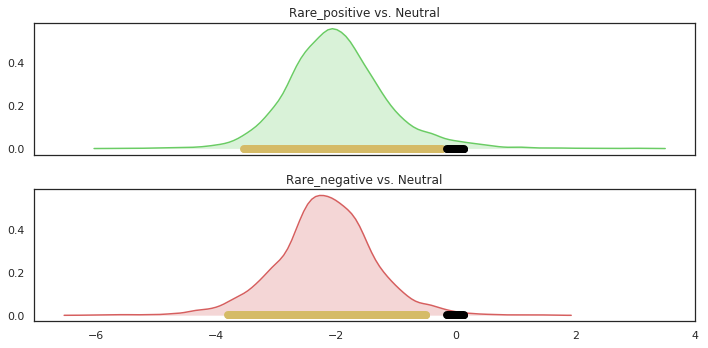

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

# import pickle
# with open("ANOVA_r2_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : model_input, 'fit' : fit}, f, protocol=-1)


fit_df = fit_no_interaction.to_dataframe()
#fit_df.to_csv('Bayesian_rmANOVA_output_r1_randomEffects.csv')
#fit_df=pd.read_csv('Bayesian_rmANOVA_output_r2_removedOutlier_groupPriorSDs_noInteraction_covaryingValueatChoice.csv')
#Extract data
chain_idx = fit_df['draw']
neutral = fit_df['mu_aW1']
positive_r = fit_df['mu_aW2']
negative_r = fit_df['mu_aW3']


#Compute Contrasts
# diff_v = rare_p-rare_t
# rares=((rare_p+rare_t)/2.0)
# all_emotion=((rare_p+rare_t+common_p)/3.0)
# diff=neutral-rares
# diff_tt=common_p-rares
# diff_common=neutral-common_p
# diff_emotion=neutral-all_emotion

#Compute HDIs
l_cp, r_cp = highest_density_interval(positive_r)
l_rp, r_rp = highest_density_interval(negative_r)

rope_val=0.14


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(2, 1, figsize=(10, 5),sharex=True)
# for ax in range(len(axs)):
#     if ax<6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.5,'0',rotation=0)
#         axs[ax].axvline(-2.41,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-2.5,-1,'Chance',rotation=0)
#     elif ax==6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.8,'0',rotation=0)

ax0=sns.distplot(positive_r, hist=False,kde_kws={"shade": True},color="g", ax=axs[0])
ax0.set(title='Rare_positive vs. Neutral',xlabel='')
axs[0].plot([l_cp, r_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-1*rope_val, rope_val],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(negative_r, hist=False,kde_kws={"shade": True},color="r", ax=axs[1])
ax1.set(title='Rare_negative vs. Neutral',xlabel='')
axs[1].plot([l_rp, r_rp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-1*rope_val, rope_val],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

plt.tight_layout()
plt.show()

In [50]:
from scipy.stats import pearsonr as corrp
worry_r1=np.load('PSWQ_Scores_round1.npy')
neg=[]
neut=[]
pos=[]
thet=[]
for sub in range(1,14):
    neg.append(np.mean(fit_df['aW3[{}]'.format(sub)]))
    pos.append(np.mean(fit_df['aW2[{}]'.format(sub)]))
    neut.append(np.mean(fit_df['aW1[{}]'.format(sub)]))
    thet.append(np.mean(fit_df['theta_neutral[{}]'.format(sub)]))

r2,pval2=corrp(neut,worry_r1)
print('BASELINE and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

r2,pval2=corrp(neg,worry_r1)
print('NEGATIVE effects and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

r2,pval2=corrp(pos,worry_r1)
print('POSITIVE effects and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))


BASELINE and Chronic Worry Correlation
corr: -0.5484142532610672, pval:0.05230457161050817

NEGATIVE effects and Chronic Worry Correlation
corr: 0.033860524155688944, pval:0.9125566933980003

POSITIVE effects and Chronic Worry Correlation
corr: -0.05830722758286756, pval:0.8499315258138866



## Conclusion re. worry

Worry may impinge on the ability to discern latent probabilistic transitions.

# Pilot Round 2: Pairing emotional and neutral stimuli within conditions

As you'll see above, this round of piloting paired salient emotional words with either rare or common transitions, within which the other type of path (common,rare) was paired with a neutral word. 

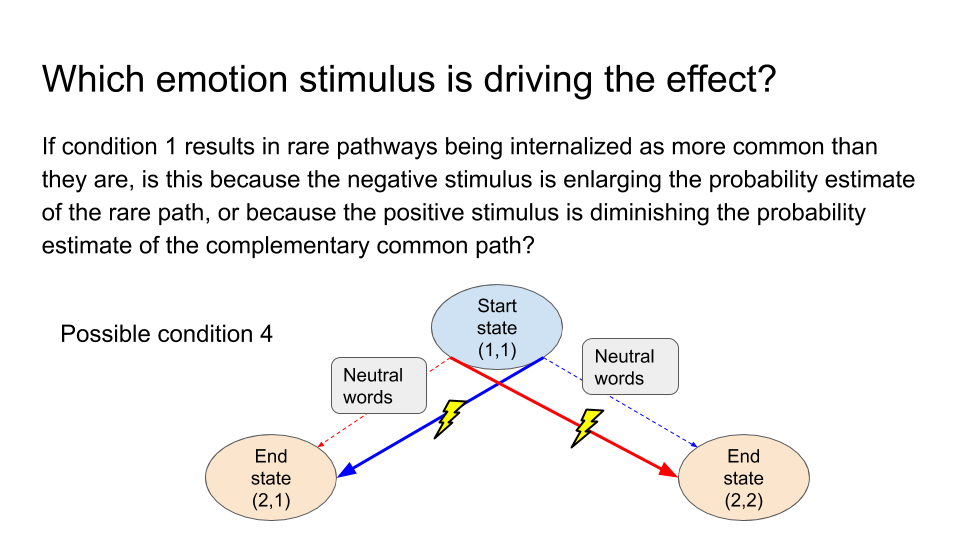

In [12]:
from IPython.display import Image
Image(filename='emotion_r2.png')

# Load self-report and choice data

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
PSWQ_scores=np.load('PSWQ_Scores_round2.npy')
choice_data_3d=np.load('data_pilot2.npy')
# print('sub 13: {}'.format(choice_data_3d[12,:,:]))
choice_data_no_sub_13=np.delete(choice_data_3d,12,axis=0)
# print('sub 13 after deletion: {}'.format(choice_data_no_sub_13[12,:,:]))
worry_noSub13=np.delete(PSWQ_scores,12)
vd=np.load('value_diff_atchoice_r2_demeaned.npy')
l=[]
vds=[]
#get array with value difference for each choice PER CONDITION 
for i in range(1,81):
    if i%20==0:
        l.append(vd[i-1])
        vds.append(l)
        l=[]
    else:
        l.append(vd[i-1])


## Build hierarchical model - Fixed Effects ANOVA

### Run analysis without subject 13, that did not seem to learn correct probabilities (consistently chose the more rare paths across conditions) and estimate group-level standard deviation on interaction and subject-level effects to induce more shrinkage.



In [15]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  // Grand mean
  real a0;
  
  //Conditions
  vector[NxConditions] aW;
  vector[NxSubjects] aS;
  
  //Group level Prior variance
  real<lower=0.01> sigma_subject;
  real<lower=0.01> sigma_condition;
  
    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_cp;
vector[NxSubjects] theta_rp;
vector[NxSubjects] theta_rt;


// Translate to sum-to-zero deflections away from Grand Mean 
real b0;
vector[NxConditions] bConditions;
vector[NxSubjects] bSubjects;

    

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  for ( u in 1:NxConditions){
      for ( b in 1: NxSubjects){
          m[u,b] = a0+aW[u]+aS[b];
      }
  }
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  
  //Effects of Subject
  for (h in 1:NxSubjects){bSubjects[h]=mean(m[1:NxConditions,h])-b0;}



for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(a0+aW[1]+aS[k]);
        theta_cp[k] = inv_logit(a0+aW[2]+aS[k]);
        theta_rp[k] = inv_logit(a0+aW[3]+aS[k]);
        theta_rt[k] = inv_logit(a0+aW[4]+aS[k]);
        
    }
}
model {

    sigma_subject ~ uniform(0.01,10);
    sigma_condition ~ uniform(0.01,10);
    
    
    a0 ~ normal(0,10);
    aS ~ normal(0,sigma_subject);
    aW ~ normal(0,sigma_condition);
    
    
    for (k in 1:NxSubjects){
                
    
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive-common choices
            Choice[k,2,:] ~ bernoulli(theta_cp[k]);

            // Positive-rare choices
            Choice[k,3,:] ~ bernoulli(theta_rp[k]); 
            
            // Threatening-rare choices
            Choice[k,4,:] ~ bernoulli(theta_rt[k]);
            
              
      }
    }
    
'''
data_input = {
              'Ntrials': 20, # trials per condition
              'Choice':choice_data_no_sub_13,#choice data
              'NxConditions':4,
              'NxSubjects':13
                    }

# controls={}
# controls['adapt_delta']=0.8

model_fit = StanModel(model_code=model_input)
fit_r2_no_interaction = model_fit.sampling(data=data_input,iter=2000)
print(fit_r2_no_interaction)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8788ef3d95ec9296e776ea7e5cf7c8d6 NOW.


Inference for Stan model: anon_model_8788ef3d95ec9296e776ea7e5cf7c8d6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0                  2.41    0.04   0.76   0.87   1.98    2.4   2.83   4.02    455   1.01
aW[1]               0.42    0.03   0.63  -0.89   0.13    0.4   0.68   1.91    399   1.01
aW[2]               0.22    0.03   0.62  -1.11  -0.04   0.21   0.47   1.56    413   1.01
aW[3]              -0.58    0.03   0.62  -1.99  -0.84  -0.57  -0.31    0.7    429   1.01
aW[4]             9.1e-3    0.03   0.62   -1.4  -0.25 8.1e-3   0.26   1.37    435   1.01
aS[1]              -1.08    0.02   0.55  -2.17  -1.43  -1.07  -0.72  -0.03    658    1.0
aS[2]               0.86    0.02   0.69   -0.4   0.38   0.83   1.29   2.34   1091    1.0
aS[3]               1.21    0.02   0.72  -0.12   0.73   1.19   1.66   2.67   1273    1.0
aS[4]     

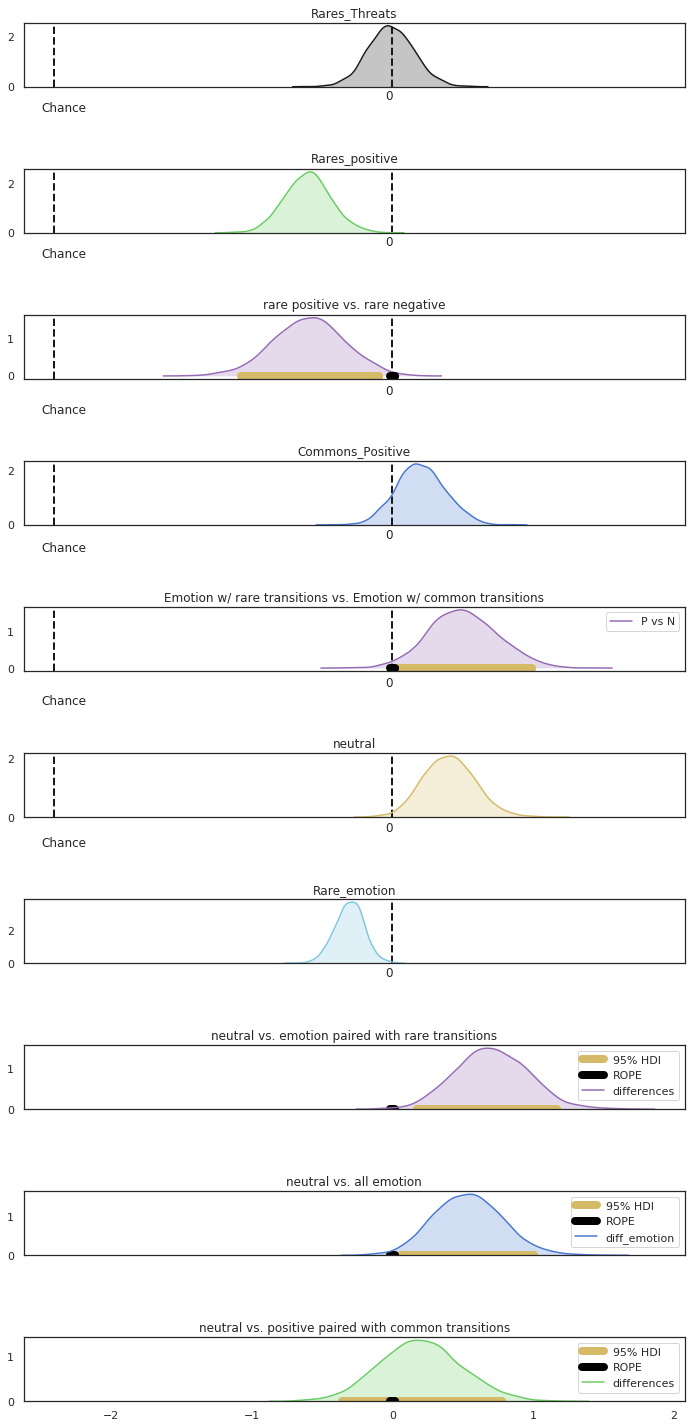

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

# import pickle
# with open("ANOVA_r2_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : model_input, 'fit' : fit}, f, protocol=-1)


fit_df = fit_r2_no_interaction.to_dataframe()
#fit_df.to_csv('Bayesian_rmANOVA_output_r2_removedOutlier_groupPriorSDs_noInteraction_covaryingValueatChoice.csv')
#fit_df=pd.read_csv('Bayesian_rmANOVA_output_r2_removedOutlier_groupPriorSDs_noInteraction.csv')
#Extract data
chain_idx = fit_df['draw']
neutral = fit_df['bConditions[1]']
common_p = fit_df['bConditions[2]']
rare_p = fit_df['bConditions[3]']
rare_t = fit_df['bConditions[4]']

#Compute Contrasts
diff_v = rare_p-rare_t
rares=((rare_p+rare_t)/2.0)
all_emotion=((rare_p+rare_t+common_p)/3.0)
diff=neutral-rares
diff_tt=common_p-rares
diff_common=neutral-common_p
diff_emotion=neutral-all_emotion

#Compute HDIs
lt, rt = highest_density_interval(diff_tt)
l, r = highest_density_interval(diff)
lp,rp=highest_density_interval(diff_common)
lv,rv=highest_density_interval(diff_v)
le,re=highest_density_interval(diff_emotion)

sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(10, 1, figsize=(10, 20),sharex=True)
for ax in range(len(axs)):
    if ax<6:
        axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
        axs[ax].text(-0.05,-0.5,'0',rotation=0)
        axs[ax].axvline(-2.41,0,lw=2.0,ls='--',color='k')
        axs[ax].text(-2.5,-1,'Chance',rotation=0)
    elif ax==6:
        axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
        axs[ax].text(-0.05,-0.8,'0',rotation=0)

ax0=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
ax0.set(title='Rares_Threats',xlabel='')

ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
ax1.set(title='Rares_positive',xlabel='')

axd=sns.distplot(diff_v, hist=False,kde_kws={"shade": True},color="m", ax=axs[2])
axd.set(title='rare positive vs. rare negative',xlabel='')
axs[2].plot([lv, rv],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax2=sns.distplot(common_p, hist=False, kde_kws={"shade": True},color="b", ax=axs[3])
ax2.set(title='Commons_Positive',xlabel='')

axv=sns.distplot(diff_tt, hist=False, kde_kws={"shade": True},color="m", ax=axs[4],label='P vs N')
axv.set(title='Emotion w/ rare transitions vs. Emotion w/ common transitions',xlabel='')

axs[4].plot([lt, rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axn=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="y", ax=axs[5])
axn.set(title='neutral',xlabel='')

axe=sns.distplot(rares, hist=False,kde_kws={"shade": True},color="c", ax=axs[6])
axe.set(title='Rare_emotion',xlabel='')

axs[7].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[7].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff, hist=False, kde_kws={"shade": True},color="m", ax=axs[7],label='differences')
ax3.set(title='neutral vs. emotion paired with rare transitions',xlabel='')

axs[8].plot([le, re],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[8].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff_emotion, hist=False, kde_kws={"shade": True},color="b", ax=axs[8],label='diff_emotion')
ax3.set(title='neutral vs. all emotion',xlabel='')

axs[9].plot([lp, rp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[9].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax4=sns.distplot(diff_common, hist=False, kde_kws={"shade": True},color="g", ax=axs[9],label='differences')
ax4.set(title='neutral vs. positive paired with common transitions',xlabel='')


plt.tight_layout()
plt.show()


# Model with covariate for value differential at each choice

In [24]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
    real vd[NxConditions, Ntrials];
}

parameters {   
  // Grand mean
  real a0;
  
  //Conditions
  vector[NxConditions] aW;
  vector[NxSubjects] aS;
  
  
  
  //Group level Prior variance
  real<lower=0.01> sigma_subject;
  real<lower=0.01> sigma_condition;
  
  //Effect of value differential at choice time
   real aVD;
  
    
}

transformed parameters {

matrix[NxSubjects,Ntrials] theta_neutral;
matrix[NxSubjects,Ntrials] theta_cp;
matrix[NxSubjects,Ntrials] theta_rp;
matrix[NxSubjects,Ntrials] theta_rt;


// Translate to sum-to-zero deflections away from Grand Mean 
real b0;
vector[NxConditions] bConditions;
vector[NxSubjects] bSubjects;

    

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  for ( u in 1:NxConditions){
      for ( b in 1: NxSubjects){
          for (x in 1: Ntrials){
              m[u,b] = a0+aW[u]+aS[b]-aVD*(0.8); //0.8 = Mean of VD metric variable
          }
       }
          
  }
  
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  
  //Effects of Subject
  for (h in 1:NxSubjects){bSubjects[h]=mean(m[1:NxConditions,h])-b0;}
    
for (k in 1:NxSubjects){
        for (x in 1:Ntrials){
        theta_neutral[k,x] = inv_logit(a0+aW[1]+aS[k]+aVD*vd[1,x]);
        theta_cp[k,x] = inv_logit(a0+aW[2]+aS[k]+aVD*vd[2,x]);
        theta_rp[k,x] = inv_logit(a0+aW[3]+aS[k]+aVD*vd[4,x]);
        theta_rt[k,x] = inv_logit(a0+aW[4]+aS[k]+aVD*vd[3,x]);
        
    }
    }
}
model {

    sigma_subject ~ uniform(0.01,10);
    sigma_condition ~ uniform(0.01,10);
    aVD ~ normal(0, 10);
    
    a0 ~ normal(0,10); 
    
    for ( j in 1:NxConditions ) { aW[j] ~ normal(0,sigma_condition); }
    
    for (k in 1:NxSubjects){
        
        aS[k] ~ normal(0,sigma_subject);
        
        for (i in 1:Ntrials) {
    
            // Neutral condition choices
            Choice[k,1,i] ~ bernoulli(theta_neutral[k,i]);

            // Positive-common choices
            Choice[k,2,i] ~ bernoulli(theta_cp[k,i]);

            // Positive-rare choices
            Choice[k,3,i] ~ bernoulli(theta_rp[k,i]); 
            
            // Threatening-rare choices
            Choice[k,4,i] ~ bernoulli(theta_rt[k,i]);
            
              }
      }
    }
    
'''
data_input = {
              'Ntrials': 20, # trials per condition
              'Choice':choice_data_no_sub_13,#choice data
              'vd': vds, #difference in options at choice
              'NxConditions':4,
              'NxSubjects':13
                    }

model_fit = StanModel(model_code=model_input)
fit_r2_no_interaction_cov = model_fit.sampling(data=data_input,iter=2000)
print(fit_r2_no_interaction_cov)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_227b92fcacd64f2a5be57fd3eb7d4485 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_227b92fcacd64f2a5be57fd3eb7d4485.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0                     2.41    0.03   0.71   0.93    2.0   2.39   2.82   3.87    450    1.0
aW[1]                  0.39    0.03   0.58  -0.76   0.11   0.37   0.66   1.66    435    1.0
aW[2]                   0.2    0.03   0.58  -0.99  -0.08   0.19   0.47    1.4    426    1.0
aW[3]                 -0.61    0.03   0.58  -1.88  -0.88  -0.58  -0.33   0.54    429    1.0
aW[4]                 -0.02    0.03   0.58  -1.24  -0.29  -0.01   0.25   1.13    429    1.0
aS[1]                 -1.05    0.02   0.52  -2.09  -1.39  -1.04  -0.71  -0.01    830    1.0
aS[2]                  0.92    0.02   0.67  -0.32   0.46   0.89   1.35   2.29   1386    1.0
aS[3]                  1.23    0.02   0.73  -0.07   0.72   1.19   1.69   2.

# Random effects model

In [19]:
from pystan import StanModel


model_input='''
data {
    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  
  //Conditions
  vector[NxSubjects] aW1_raw;
  vector[NxSubjects] aW2_raw;
  vector[NxSubjects] aW3_raw;
  vector[NxSubjects] aW4_raw;
  
  //Group level Prior variance
  real<lower=0.01> sigma_neutral;
  real<lower=0.01> sigma_cp;
  real<lower=0.01> sigma_rp;
  real<lower=0.01> sigma_rt;
  
  //Group level mus
  real mu_neutral;
  real mu_cp;
  real mu_rp;
  real mu_rt;
    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_cp;
vector[NxSubjects] theta_rp;
vector[NxSubjects] theta_rt;


  vector[NxSubjects] aW1;
  vector[NxSubjects] aW2;
  vector[NxSubjects] aW3;
  vector[NxSubjects] aW4;

// Non-Centered Parameterization

  aW1 = mu_neutral + sigma_neutral * aW1_raw;
  aW2 = mu_cp + sigma_cp * aW2_raw;
  aW3 = mu_rp + sigma_rp * aW3_raw;
  aW4 = mu_rt + sigma_rt * aW4_raw;

for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(aW1[k]);
        theta_cp[k] = inv_logit(aW1[k]+aW2[k]);
        theta_rp[k] = inv_logit(aW1[k]+aW3[k]);
        theta_rt[k] = inv_logit(aW1[k]+aW4[k]);
    }
    
}
model {
    
    mu_neutral ~ normal(0,10);
    sigma_neutral ~ uniform(0.01,10);
    mu_cp ~ normal(0,10);
    sigma_cp ~ uniform(0.01,10);
    mu_rp ~ normal(0,10);
    sigma_rp ~ uniform(0.01,10);
    mu_rt ~normal(0,10);
    sigma_rt ~ uniform(0.01,10);
    
    aW1_raw ~ std_normal();
    aW2_raw ~ std_normal();
    aW3_raw ~ std_normal();
    aW4_raw ~ std_normal();
        
    for (k in 1:NxSubjects){
            
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive-common choices
            Choice[k,2,:] ~ bernoulli(theta_cp[k]);

            // Positive-rare choices
            Choice[k,3,:] ~ bernoulli(theta_rp[k]); 
            
            // Threatening-rare choices
            Choice[k,4,:] ~ bernoulli(theta_rt[k]);
            
              
      }
    }
    
'''
data_input = {
              'Ntrials': 20, # trials per condition
              'Choice':choice_data_no_sub_13,#choice datas
              'NxConditions':4,
              'NxSubjects':13
                    }

model_fit = StanModel(model_code=model_input)
fit_r2_RE = model_fit.sampling(data=data_input,iter=2000)
print(fit_r2_RE)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44827205f801a026cab8fc9d6001b0d9 NOW.


Inference for Stan model: anon_model_44827205f801a026cab8fc9d6001b0d9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
aW1_raw[1]          0.28    0.01   0.54  -0.71  -0.08   0.26   0.61   1.43   1631    1.0
aW1_raw[2]          0.68    0.01    0.6  -0.36   0.24   0.65   1.06   1.96   2680    1.0
aW1_raw[3]          0.78    0.01   0.62   -0.3   0.35   0.74   1.16   2.12   2425    1.0
aW1_raw[4]          0.33    0.01   0.53  -0.64  -0.04    0.3   0.68   1.46   2263    1.0
aW1_raw[5]          0.28    0.01    0.5  -0.66  -0.06   0.26   0.61   1.31   2396    1.0
aW1_raw[6]          0.19    0.01   0.51  -0.76  -0.16   0.16    0.5   1.26   2090    1.0
aW1_raw[7]         -1.83    0.01   0.53  -2.93  -2.18  -1.82  -1.46  -0.86   1583    1.0
aW1_raw[8]          1.24    0.01    0.7  -0.05   0.77   1.21   1.69   2.71   3235    1.0
aW1_raw[9]

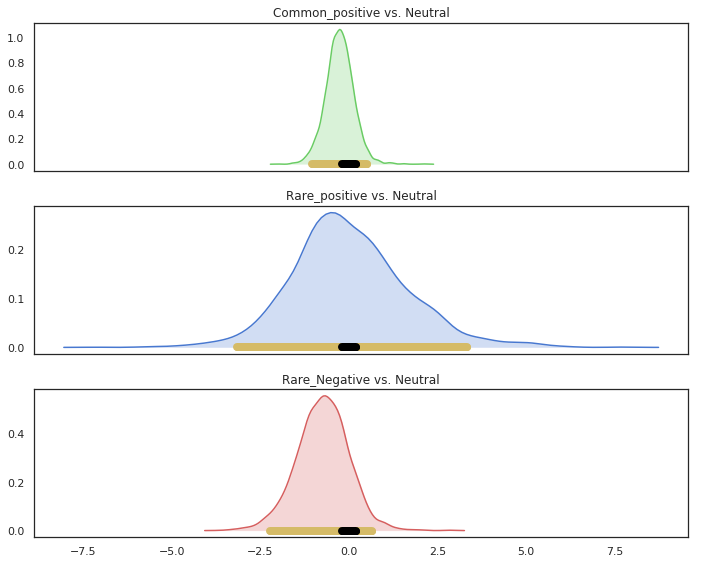

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

# import pickle
# with open("ANOVA_r2_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : model_input, 'fit' : fit}, f, protocol=-1)


fit_df_2 = fit_r2_RE.to_dataframe()
#fit_df_2.to_csv('Bayesian_r2_RandomEffects.csv')
#fit_df=pd.read_csv('Bayesian_rmANOVA_output_r2_removedOutlier_groupPriorSDs_noInteraction_covaryingValueatChoice.csv')
#Extract data
chain_idx = fit_df_2['draw']
neutral = fit_df_2['mu_neutral']
common_p = fit_df_2['mu_cp']
rare_p = fit_df_2['mu_rp']
rare_t = fit_df_2['mu_rt']

#Compute Contrasts
# diff_v = rare_p-rare_t
# rares=((rare_p+rare_t)/2.0)
# all_emotion=((rare_p+rare_t+common_p)/3.0)
# diff=neutral-rares
# diff_tt=common_p-rares
# diff_common=neutral-common_p
# diff_emotion=neutral-all_emotion

#Compute HDIs
l_cp, r_cp = highest_density_interval(common_p)
l_rp, r_rp = highest_density_interval(rare_p)
l_rt,r_rt=highest_density_interval(rare_t)

rope_val=0.197


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(3, 1, figsize=(10, 8),sharex=True)
# for ax in range(len(axs)):
#     if ax<6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.5,'0',rotation=0)
#         axs[ax].axvline(-2.41,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-2.5,-1,'Chance',rotation=0)
#     elif ax==6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.8,'0',rotation=0)

ax0=sns.distplot(common_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[0])
ax0.set(title='Common_positive vs. Neutral',xlabel='')
axs[0].plot([l_cp, r_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-1*rope_val, rope_val],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
ax1.set(title='Rare_positive vs. Neutral',xlabel='')
axs[1].plot([l_rp, r_rp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-1*rope_val, rope_val],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax2=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="r", ax=axs[2])
ax2.set(title='Rare_Negative vs. Neutral',xlabel='')
axs[2].plot([l_rt, r_rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-1*rope_val, rope_val],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

plt.tight_layout()
plt.show()


## Exploratory analysis with chronic worry

Below I take the means of each posterior distribution over the interaction effect of negative threats paired with rare transition and subject effects.

In [42]:
from scipy.stats import pearsonr as corrp
from scipy.stats import pearsonr as corrp
worry_r2=worry_noSub13
neg=[]
neut=[]
pos=[]
pos_common=[]

for sub in range(1,14):
    neg.append(np.mean(fit_df_2['aW4[{}]'.format(sub)]))
    pos.append(np.mean(fit_df_2['aW3[{}]'.format(sub)]))
    neut.append(np.mean(fit_df_2['aW1[{}]'.format(sub)]))
    pos_common.append(np.mean(fit_df_2['aW2[{}]'.format(sub)]))

r2,pval2=corrp(neut,worry_r2)
print('BASELINE and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

r2,pval2=corrp(neg,worry_r2)
print('NEGATIVE rare effects and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

r2,pval2=corrp(pos,worry_r2)
print('POSITIVE rare effects and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

r2,pval2=corrp(pos_common,worry_r2)
print('POSITIVE common effects and Chronic Worry Correlation')
print('corr: {}, pval:{}\n'.format(r2,pval2))

BASELINE and Chronic Worry Correlation
corr: -0.4661151874216995, pval:0.10839567830391479

NEGATIVE rare effects and Chronic Worry Correlation
corr: -0.09418722299339029, pval:0.7595593402720949

POSITIVE rare effects and Chronic Worry Correlation
corr: -0.5484255501117432, pval:0.05229872986208574

POSITIVE common effects and Chronic Worry Correlation
corr: 0.03380718579829624, pval:0.9126939650056085



## Variation due to subject greater than that due to experimental conditions

In [25]:
print('Range of variation due to subjects (all deflections from Grand Mean):\n')
print('Minimum subject effect:{}, Maximum: {}, Range={}\n'.format(min(subject_effects),max(subject_effects),
                                                                (max(subject_effects)-min(subject_effects))))
print('Range of variation due to experimental effects:\n')
print('Minimum condition effect:{}, Maximum: {}, Range={}'.format(min(experimental_effects),max(experimental_effects),
                                                                (max(experimental_effects)-min(experimental_effects))))

Range of variation due to subjects (all deflections from Grand Mean):

Minimum subject effect:-1.7081345061057096, Maximum: 2.313543073879423, Range=4.021677579985132

Range of variation due to experimental effects:

Minimum condition effect:-0.5986961377704842, Maximum: 0.4013676271626259, Range=1.00006376493311


## Relationship between dispositional worry and in-task mood

In [26]:
#get current mood
import numpy as np
from scipy.stats import pearsonr as corrp
cm=np.load('selfreportmood_r2.npy',allow_pickle=True)
removed_bad_sub_srMood=np.delete(cm,12).astype(int)
without_outlier_mood=np.delete(removed_bad_sub_srMood,2)
worry_noSub13_noOutlier=np.delete(worry_noSub13,2)
print(removed_bad_sub_srMood)
print(without_outlier_mood)
print('\n')
print('\n Self-Reported Mood and Chronic Worry Correlation:')
r,pval=corrp(removed_bad_sub_srMood,worry_noSub13)
print('correlation: {}, pval: {}'.format(r,pval))

print('\n Self-Reported Mood and Chronic Worry Correlation no outlier:')
r,pval=corrp(without_outlier_mood,worry_noSub13_noOutlier)
print('correlation: {}, pval: {}'.format(r,pval))



[56 69 11 60 51 74 72 53 63 77 88 50 73]
[56 69 60 51 74 72 53 63 77 88 50 73]



 Self-Reported Mood and Chronic Worry Correlation:
correlation: 0.1688116939003909, pval: 0.5814191297055131

 Self-Reported Mood and Chronic Worry Correlation no outlier:
correlation: 0.2530315268499183, pval: 0.4274917330535801


# 1. Worry is associated with deficits in performance

Model-based learning and planning could be deficient in different clinical populations for different reasons:
1. **Learning transition probabilities**. An inability to learn probabilities could lead to an intolerance of uncertainty, given that these probabilities are percieved as closer to 50-50, which prevents the agent from controlling their environment (outcomes are not tethered to actions, entirely random). 
2. **More uncertainty over transition probabilities**. Higher variance over estimates of transition probabilities could result in participants sometimes sampling a higher estimate of the objectively less-likely transition probability relative to the objectively more-likely state transition
    - This uncertainty could be encoded in either the distribution over state transition estimates or in the decision noise a the decision phase. 

**Next steps**:
Find other self-report measures of psychopathology. Present results could simply be a stress finding --> the extent to which I'm currently stressed predicts how much worse I do. **However, if current mood relates to current stress, chronic worry here is unrelated to current mood.**

**Relevant literature**:
- Gillan et al (2016) model-based learning related to compulsivity (**should account for this in future study**)
- Heller et al (2018) found no effect of anxiety on the impact of stress diminishing model-based control.
- Gillan et al (2019) Experimentally-induced and real-world acute anxiety have no effect on goal-directed behaviour.

# 2. How emotional distraction affects learning state transitions & planning

Here we show that when emotions words are interposed between learning state transitions, it selectively impairs learning when paired with uncommon transitions. Given that when emotional stimuli are paired with common transitions (more frequent) result in significantly better performance relative to when they're paired with rare transitions, emotional stimuli do not simply "distract", assuming that distraction is monotonically related to the number of distractions. 


- A simple explanation is that salient words garner an attentional bias, and this boosts memory for the attended transition. 


- A consistent explanation is that salient words garner attention because they are cues for "background goals" the agent has:

    - Task-goal: discern which transition is more common given an action

    - Background-goal: avoid threatening content represented in words or pursue positive rewards
    - **Appraisal theory**: stimulus is emotional to the extent it is relevant to the individual’s goals
    - **Cybernetic theory of Psychopathology (DeYoung)**: Low Conscientiousness is a risk factor for psychopathology (Kotov et al., 2010), associated with poor prioritizing of goals and sequencing of actions.


**Possible interpretation**: When attention is split between two goals, it impinges on learning and/or planning. The task can thus be thought of as a model of how intrusive emotional thoughts disrupt learning / planning.

**Relevant litertature**:
- Strange et al (2003): Emotion words impinge on episodic memory: "We demonstrate that emotional stimuli evoke a graded retrograde amnesia that spans at least 6 s, or two stimuli" 
    - Here, this would mean that emotion words would impinge on the recall of the last state transition.

# Tasks should model the management of multiple goals

Although tasks constrain agents to a singular goal (maximize reward on the present task by doing XYZ), in daily life, we need to manage multiple goals. Optimal management of mutiple goals likely has to do with being able to inhibit irrelevant task representations relevant for temporally distal 'background goals' (e.g., am I prepared for my talk 5 days from now) impinging upon task representations of the goal at-hand (have I reviewed what I need to for my meeting tomorrow).

The present task can be thought of "enforcing" an agent to confront and then inhibit task irrelevant representations that are relevant for background goals in order to manage the task at-hand.

## Disentangling IT from LR on performance by varying number of trials for learning

$S$ = States

$A$ = Actions

$\eta$ = Learning rate for state transitions

$O$ = Observed state 

$V$ = $P(S_{next}|A_{i},S_{current})$

$V_{i+1}=V_{i} + \eta \cdot (O-V_{i})$

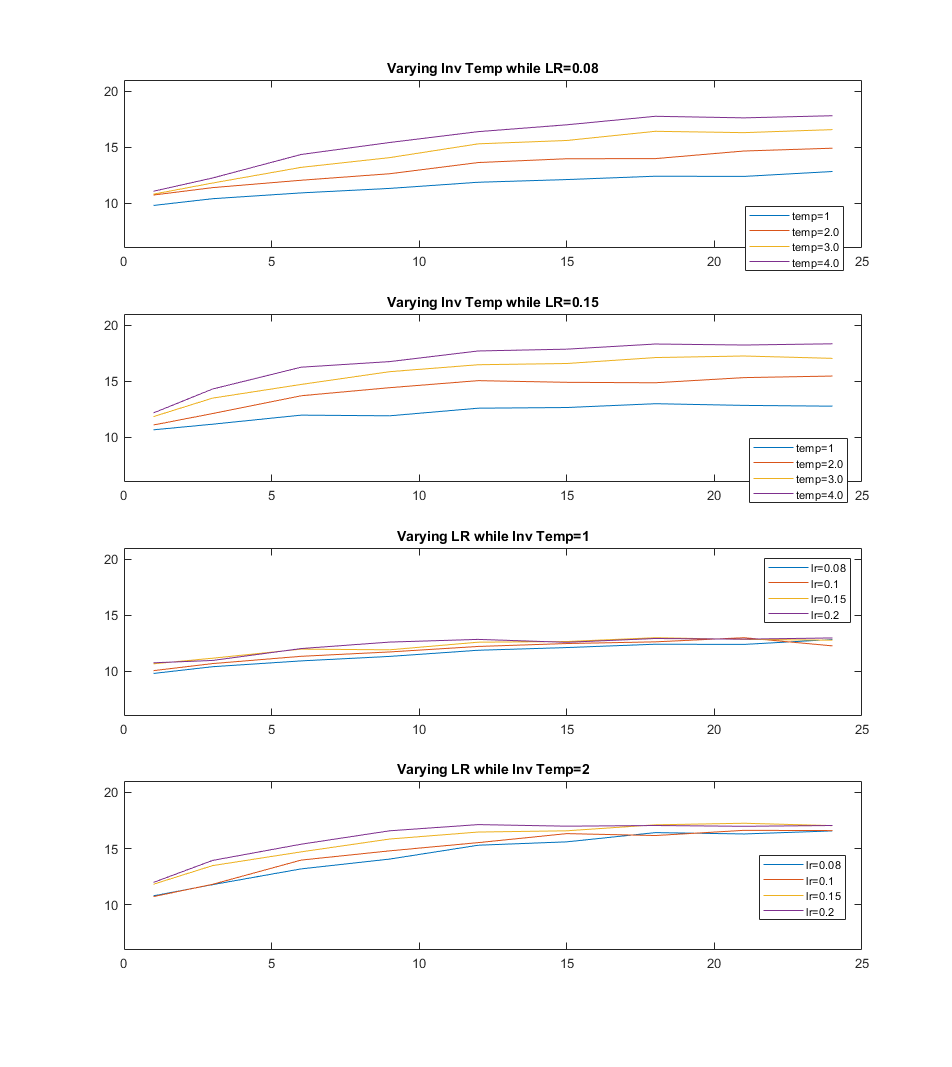

In [2]:
from IPython.display import Image
Image(filename='lr_v_it.png')